In [151]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.utils import class_weight, compute_class_weight, shuffle
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.svm import SVR
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
% matplotlib inline
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 0

In [2]:
file = pd.read_csv("data.csv", encoding = "ISO-8859-1") #read in the data

In [134]:
file.head(2) #Quick check of the data

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,aspect_ratio,movie_facebook_likes,imdb_score
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,1.78,33000,7.9
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,2.35,0,7.1


In [4]:
#preprocessing function for cleaning and dropping rows with NA's
def preprocess(filepath):
    df = filepath
    shape = df.shape
    print("\nfile dimensions: ", shape)
    lim = 0.3*shape[0]
    features = df.columns.values
    features = features.tolist()
    print("\nColumns in dataframe: ",features)
    pick = []
    for x in features:
        print("Number of NA in " , x ,": ", df[x].isnull().sum())
        xna = df[x].isnull().sum()
        if xna < lim:
            pick.append(x)
        else:
            pass
    print("\nDROP COLUMNS WITH MORE THAN 30 PERCENT NA")
    print(len(features) - len(pick), " columns were dropped")
    print("\n",pick)

    df2 = df[pick]  #subset the dataframe with the selected columns
    print("\nThe new dimension: ",df2.shape)

    print("\nDROP ROWS WITH NA")
    df3 = df2.dropna(axis=0, how='any') #drop rows with NA's

    print("\nClean dataframe dimension ", df3.shape[0], " rows and", df3.shape[1], " columns")

    return df3

In [5]:
data = preprocess(file) #run the function


file dimensions:  (5043, 27)

Columns in dataframe:  ['director_name', 'num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name', 'movie_title', 'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language', 'country', 'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes', 'imdb_score']
Number of NA in  director_name :  104
Number of NA in  num_critic_for_reviews :  50
Number of NA in  duration :  15
Number of NA in  director_facebook_likes :  104
Number of NA in  actor_3_facebook_likes :  23
Number of NA in  actor_2_name :  13
Number of NA in  actor_1_facebook_likes :  7
Number of NA in  gross :  884
Number of NA in  genres :  0
Number of NA in  actor_1_name :  7
Number of NA in  movie_title :  0
Number of NA in  num_voted_users 

In [6]:
data.head()  #Quick check of cleaned dataframe

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,aspect_ratio,movie_facebook_likes,imdb_score
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,1.78,33000,7.9
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,2.35,0,7.1
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,2.35,85000,6.8
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,2.35,164000,8.5
5,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,2.35,24000,6.6


In [25]:
#Function to remove categorical features with more than 1% unique values to avoid our dataframe becoming to wide and sparse
def removeUcol(df):
    features = df.columns.values
    features = features.tolist()
    clist = []
    for a in features:
        if df[a].dtype == "object":
            clist.append(a)
        else:
            pass
#     features = features.tolist()
    for x in clist:  
        y = len(set(df[x]))
        z = 0.1*(len(df[x]))
        if  y > z:
            features.remove(x)
        else:
            pass
    df = df[features]
    return df

In [26]:
data2 = removeUcol(data) #run the function

In [87]:
data2.describe(include='all')  #Check descriptive stats

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,aspect_ratio,movie_facebook_likes,imdb_score
count,3757.000000,3757.000000,3757.000000,3757.000000,3757.000000,3.757000e+03,3.757000e+03,3757.000000,3757.000000,3757.000000,3757,3757,3757,3.757000e+03,3757.000000,3757.000000,3757.000000,3757.000000,3757.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,45,12,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,English,USA,R,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3599,2987,1700,NaN,NaN,NaN,NaN,NaN,NaN
mean,167.348682,110.256322,807.137876,771.194304,7749.534735,5.259918e+07,1.057994e+05,11524.680596,1.376896,336.759382,NaN,NaN,NaN,4.622614e+07,2002.978706,2021.396061,2.111078,9351.339633,6.465185
std,123.448979,22.643932,3067.787384,1894.004897,15517.667480,7.031348e+07,1.520244e+05,19120.207220,2.041392,411.204705,NaN,NaN,NaN,2.259812e+08,9.887658,4544.362793,0.353043,21460.574376,1.056123
min,2.000000,37.000000,0.000000,0.000000,0.000000,1.620000e+02,9.100000e+01,0.000000,0.000000,4.000000,NaN,NaN,NaN,2.180000e+02,1927.000000,0.000000,1.180000,0.000000,1.600000
25%,77.000000,96.000000,11.000000,194.000000,745.000000,8.243880e+06,1.965500e+04,1920.000000,0.000000,110.000000,NaN,NaN,NaN,1.000000e+07,1999.000000,385.000000,1.850000,0.000000,5.900000
50%,138.000000,106.000000,64.000000,436.000000,1000.000000,3.009311e+07,5.397000e+04,4059.000000,1.000000,210.000000,NaN,NaN,NaN,2.500000e+07,2004.000000,685.000000,2.350000,227.000000,6.600000
75%,224.000000,120.000000,235.000000,691.000000,13000.000000,6.686207e+07,1.285930e+05,16237.000000,2.000000,398.000000,NaN,NaN,NaN,5.000000e+07,2010.000000,976.000000,2.350000,11000.000000,7.200000


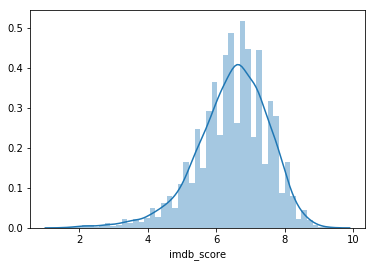

In [11]:
sns.distplot(data.imdb_score)  #check distribution graph of some of the features

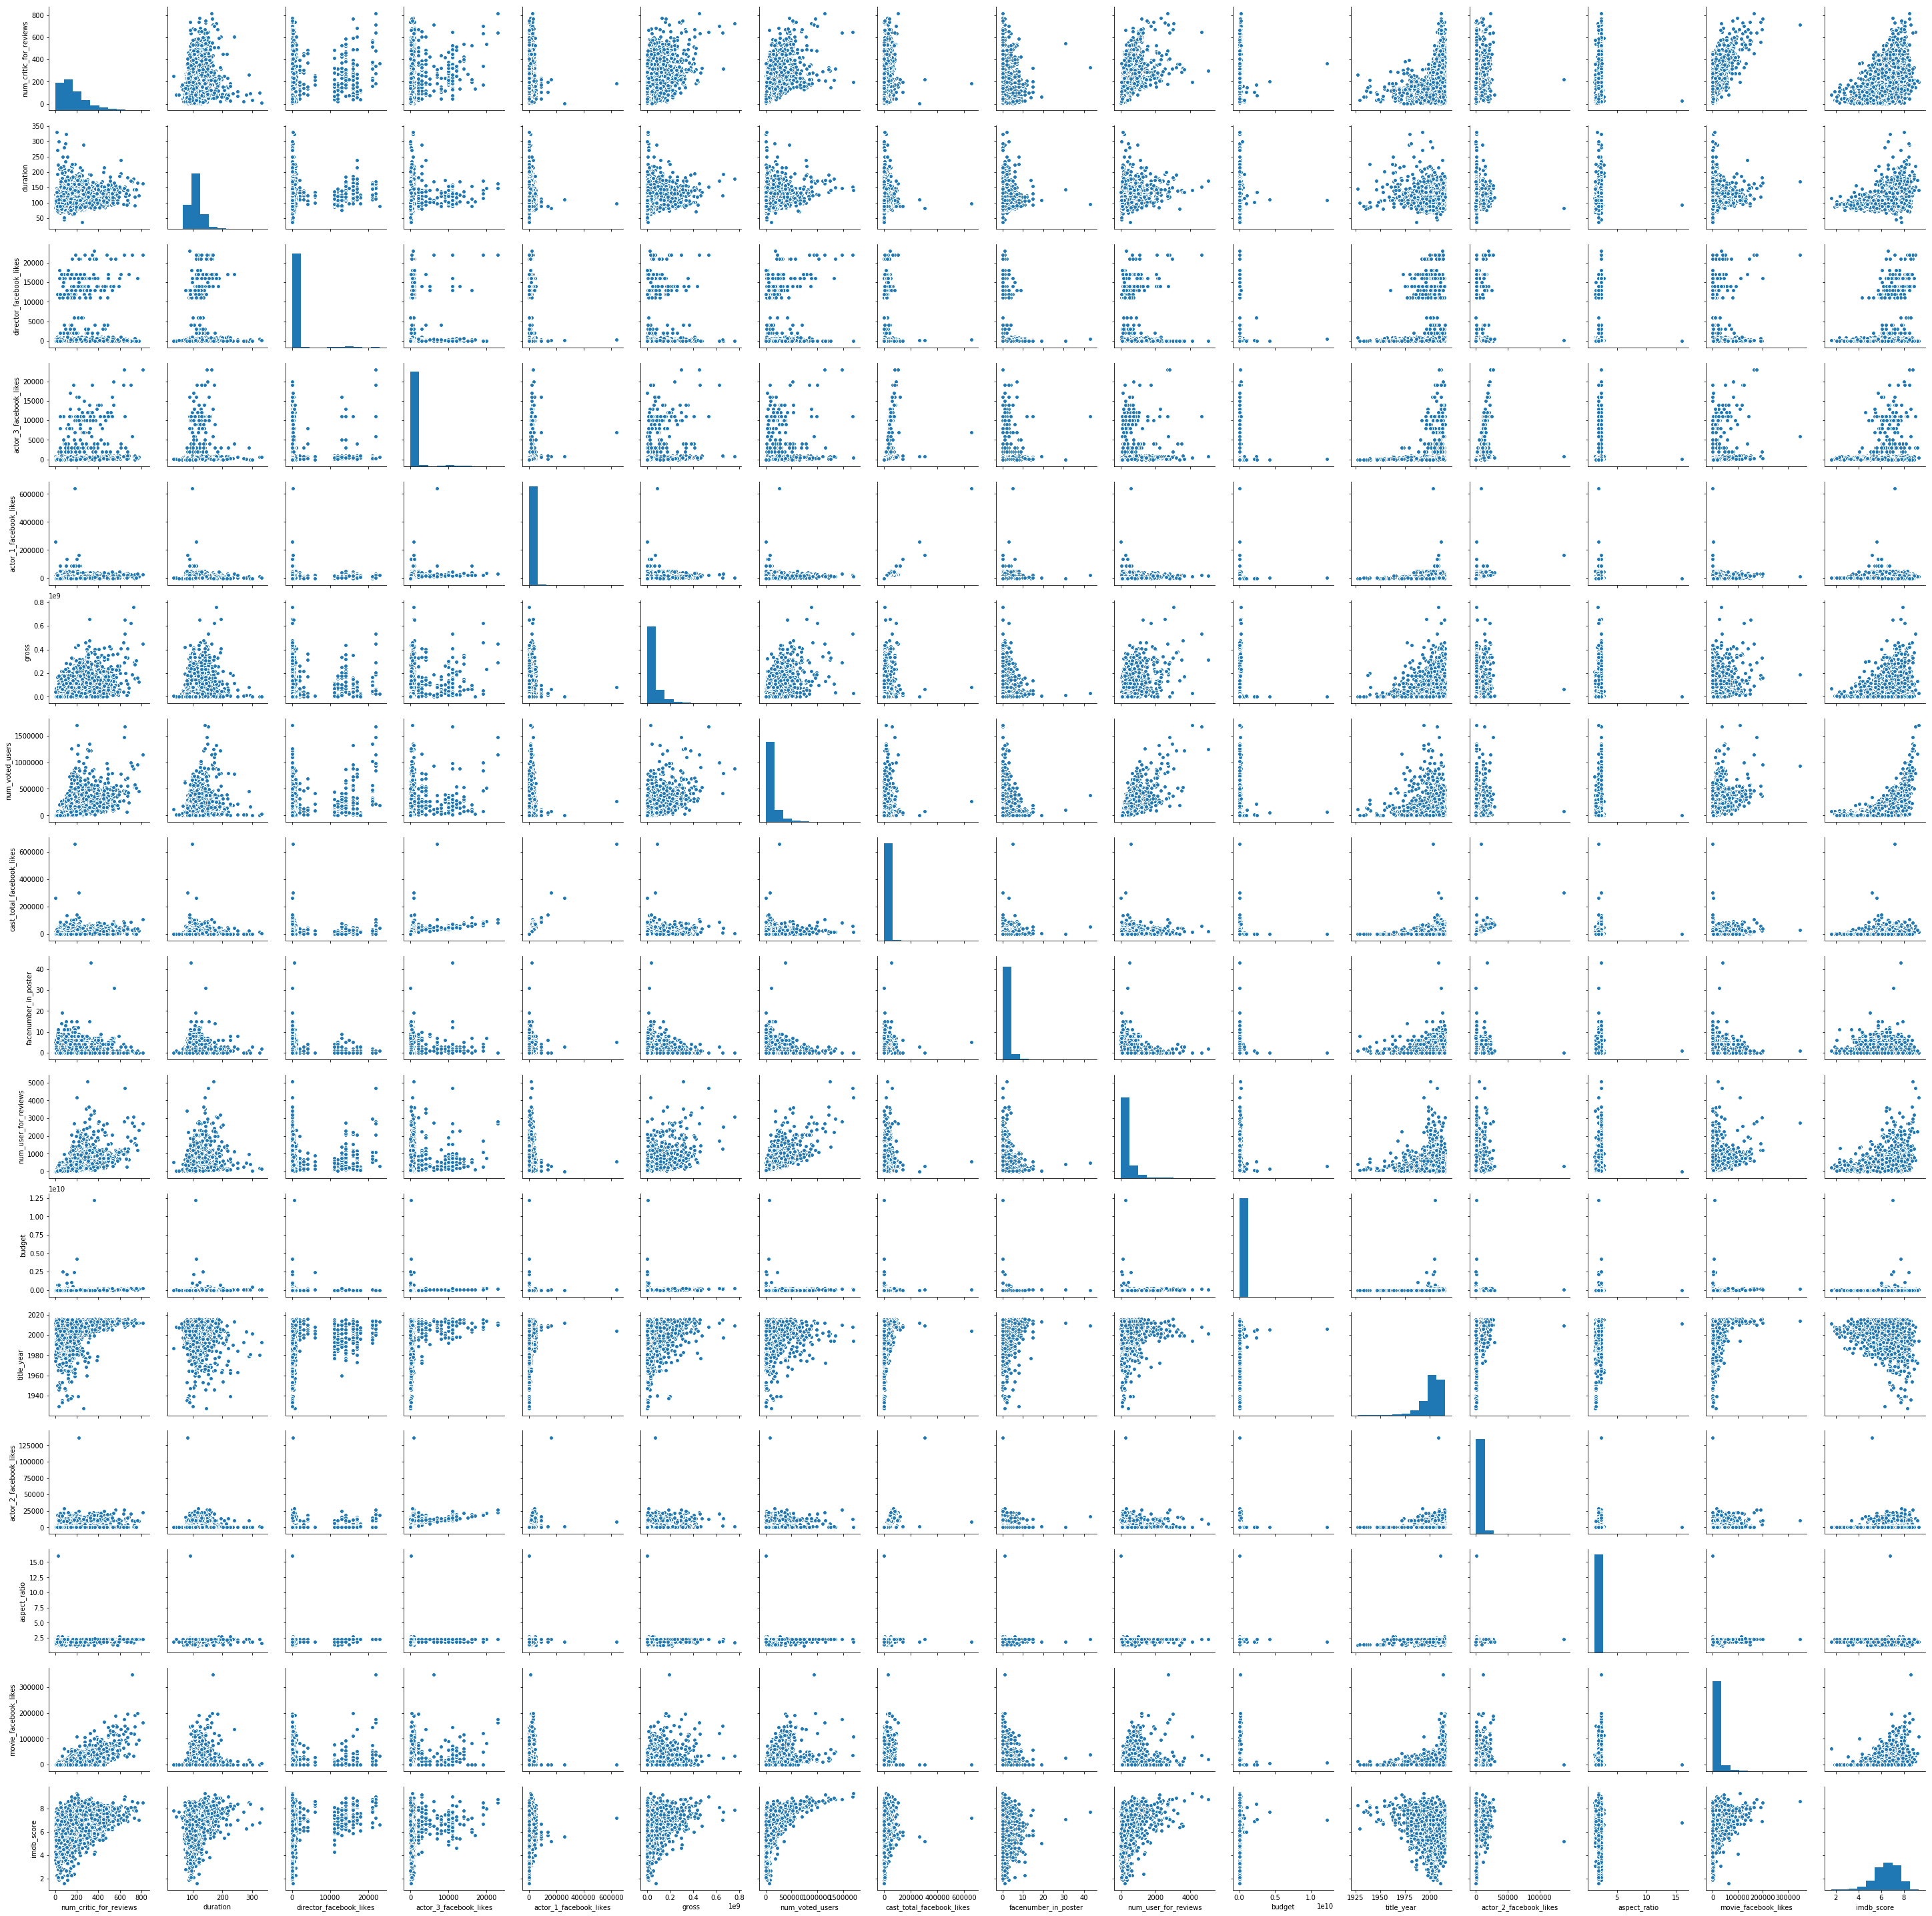

In [26]:
sns.pairplot(data)

In [28]:
data2.shape  #data contains 19 ccolumns before one hot encoding

(3757, 19)

In [29]:
df = shuffle(data2, random_state=12)   #Shuffle

In [30]:
df.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'budget', 'title_year', 'actor_2_facebook_likes', 'aspect_ratio',
       'movie_facebook_likes', 'imdb_score'],
      dtype='object')

In [32]:
#dbreak data in X and Y
X = df[['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'budget', 'title_year', 'actor_2_facebook_likes', 'aspect_ratio',
       'movie_facebook_likes']]
Y = df['imdb_score']

In [33]:
X_encoded = pd.get_dummies(X)  #one hot encoding

In [34]:
print(X.shape)  # former shape
print(X_encoded.shape)   #cureent shape

(3757, 18)
(3757, 106)


In [36]:
cols = list(X_encoded.columns)  #create a list of all the column names

In [37]:
#scale the X
scaler = MinMaxScaler(feature_range = (0,1))  
X_scaled = scaler.fit_transform(X_encoded)

In [38]:
X_scaled = pd.DataFrame(X_scaled, columns =cols)

In [39]:
X_scaled.head(1)  #confirm data is scaled

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,aspect_ratio,movie_facebook_likes,language_Aboriginal,language_Arabic,language_Aramaic,language_Bosnian,language_Cantonese,language_Czech,language_Danish,language_Dari,language_Dutch,language_English,language_Filipino,language_French,language_German,language_Hebrew,language_Hindi,language_Hungarian,language_Indonesian,language_Italian,language_Japanese,language_Kazakh,language_Korean,language_Mandarin,language_Maya,language_Mongolian,language_None,language_Norwegian,language_Persian,language_Portuguese,language_Romanian,language_Russian,language_Spanish,language_Thai,language_Vietnamese,language_Zulu,country_Afghanistan,country_Argentina,country_Aruba,country_Australia,country_Belgium,country_Brazil,country_Canada,country_Chile,country_China,country_Colombia,country_Czech Republic,country_Denmark,country_Finland,country_France,country_Georgia,country_Germany,country_Greece,country_Hong Kong,country_Hungary,country_Iceland,country_India,country_Indonesia,country_Iran,country_Ireland,country_Israel,country_Italy,country_Japan,country_Mexico,country_Netherlands,country_New Line,country_New Zealand,country_Norway,country_Official site,country_Peru,country_Poland,country_Romania,country_Russia,country_South Africa,country_South Korea,country_Spain,country_Taiwan,country_Thailand,country_UK,country_USA,country_West Germany,content_rating_Approved,content_rating_G,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_Unrated,content_rating_X
0,0.228113,0.16041,0.003957,0.008957,0.000905,0.140425,0.083098,0.002767,0.0,0.070016,0.003684,0.820225,0.003869,0.045209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
#splitting into train and test
Xtr, Xte, Ytr, Yte = train_test_split(X_scaled, Y, test_size=0.20)

In [41]:
#checking dimensions
print('Training Shape:', Xtr.shape)
print('Training response Shape:', Ytr.shape)
print('Testing Shape:', Xte.shape)
print('Testing response Shape:', Yte.shape)

Training Shape: (3005, 106)
Training response Shape: (3005,)
Testing Shape: (752, 106)
Testing response Shape: (752,)


## Starting Random Forest Regression

In [80]:
# Perform Grid-Search
gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(7,10,15),
        'n_estimators': (10, 50, 100, 1000, 5000),
    },
    cv=3, scoring='r2', verbose=0, n_jobs=-1)

grid_result = gsc.fit(Xtr, Ytr)
best_params = grid_result.best_params_

In [81]:
#Build and train model
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
rfr.fit(Xtr, Ytr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=False, verbose=False,
           warm_start=False)

In [82]:
#Check for most important features
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
print ("Features sorted by their score:")
for f in range(X_scaled.shape[1]):
    print(f + 1, cols[indices[f]]," - ", importances[indices[f]])

Features sorted by their score:
1 num_voted_users  -  0.4552234321489055
2 duration  -  0.1317363213612399
3 budget  -  0.12589733720635563
4 num_user_for_reviews  -  0.058743937193181266
5 gross  -  0.04675482958779274
6 num_critic_for_reviews  -  0.03113281635306656
7 title_year  -  0.025653611002550012
8 actor_3_facebook_likes  -  0.016836740888266578
9 cast_total_facebook_likes  -  0.015333373236585872
10 actor_2_facebook_likes  -  0.01436430769934937
11 movie_facebook_likes  -  0.014225748482370765
12 director_facebook_likes  -  0.009440660898834522
13 content_rating_PG-13  -  0.008814741537915166
14 facenumber_in_poster  -  0.008555686988676075
15 actor_1_facebook_likes  -  0.008409633337308904
16 language_English  -  0.006129032987589602
17 country_USA  -  0.005901761689938395
18 content_rating_G  -  0.004013284012616078
19 content_rating_R  -  0.003549030066543733
20 aspect_ratio  -  0.001595385203053961
21 language_Bosnian  -  0.001531773706255911
22 content_rating_PG  -  0.00

In [83]:
#Predict
predictions = rfr.predict(Xte)

In [84]:
#Check R2
r2_score(Yte, predictions)

0.5858222537199462

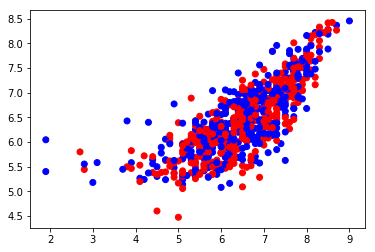

In [145]:
plt.scatter(Yte, predictions, c=("red","blue"))  #scatter plot of actual vs predicted

## Artificial Neural Network

In [86]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [135]:
#Build Artificial Neural Network model -3 hidden layers

n_cols = Xtr.shape[1]
print(n_cols)
def ann_regressor():
    model = Sequential()
    model.add(Dense(units=128, input_dim=n_cols, ))
    model.add(Dense(units=64))
    model.add(Dense(units=32))
    model.add(Dense(units=1))
    model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae','accuracy'])
    return model

106


In [136]:
# We will train of train data and immediately validate on the test data
regressor = KerasRegressor(build_fn=build_regressor, batch_size=32,epochs=200, validation_data=(Xte, Yte))

In [137]:
results=regressor.fit(Xtr,Ytr) #run model

Train on 3005 samples, validate on 752 samples
Epoch 1/200
3005/3005 [==============================] - 3s 993us/step - loss: 2.6161 - mean_absolute_error: 1.0936 - acc: 0.0296 - val_loss: 0.8751 - val_mean_absolute_error: 0.7078 - val_acc: 0.0439
Epoch 2/200
3005/3005 [==============================] - 0s 85us/step - loss: 1.0257 - mean_absolute_error: 0.7913 - acc: 0.0346 - val_loss: 0.9151 - val_mean_absolute_error: 0.7164 - val_acc: 0.0465
Epoch 3/200
3005/3005 [==============================] - 0s 86us/step - loss: 0.9053 - mean_absolute_error: 0.7372 - acc: 0.0406 - val_loss: 0.7070 - val_mean_absolute_error: 0.6462 - val_acc: 0.0465
Epoch 4/200
3005/3005 [==============================] - 0s 143us/step - loss: 0.8894 - mean_absolute_error: 0.7271 - acc: 0.0373 - val_loss: 1.0203 - val_mean_absolute_error: 0.7698 - val_acc: 0.0359
Epoch 5/200
3005/3005 [==============================] - 1s 232us/step - loss: 0.8244 - mean_absolute_error: 0.6958 - acc: 0.0389 - val_loss: 0.6436 - 

Epoch 82/200
3005/3005 [==============================] - 0s 74us/step - loss: 0.7005 - mean_absolute_error: 0.6337 - acc: 0.0429 - val_loss: 0.6642 - val_mean_absolute_error: 0.6368 - val_acc: 0.0372
Epoch 83/200
3005/3005 [==============================] - 0s 74us/step - loss: 0.6962 - mean_absolute_error: 0.6299 - acc: 0.0413 - val_loss: 0.6311 - val_mean_absolute_error: 0.6042 - val_acc: 0.0479
Epoch 84/200
3005/3005 [==============================] - 0s 85us/step - loss: 0.6944 - mean_absolute_error: 0.6315 - acc: 0.0419 - val_loss: 0.6263 - val_mean_absolute_error: 0.6058 - val_acc: 0.0439
Epoch 85/200
3005/3005 [==============================] - 0s 85us/step - loss: 0.7024 - mean_absolute_error: 0.6338 - acc: 0.0439 - val_loss: 0.6648 - val_mean_absolute_error: 0.6419 - val_acc: 0.0386
Epoch 86/200
3005/3005 [==============================] - 0s 79us/step - loss: 0.7051 - mean_absolute_error: 0.6372 - acc: 0.0453 - val_loss: 0.6207 - val_mean_absolute_error: 0.6072 - val_acc: 0.

Epoch 123/200
3005/3005 [==============================] - 0s 66us/step - loss: 0.6912 - mean_absolute_error: 0.6300 - acc: 0.0456 - val_loss: 0.6230 - val_mean_absolute_error: 0.6145 - val_acc: 0.0372
Epoch 124/200
3005/3005 [==============================] - 0s 66us/step - loss: 0.6858 - mean_absolute_error: 0.6279 - acc: 0.0443 - val_loss: 0.6127 - val_mean_absolute_error: 0.6046 - val_acc: 0.0386
Epoch 125/200
3005/3005 [==============================] - 0s 74us/step - loss: 0.6936 - mean_absolute_error: 0.6316 - acc: 0.0453 - val_loss: 0.6100 - val_mean_absolute_error: 0.6038 - val_acc: 0.0386
Epoch 126/200
3005/3005 [==============================] - 0s 78us/step - loss: 0.6835 - mean_absolute_error: 0.6247 - acc: 0.0453 - val_loss: 0.6120 - val_mean_absolute_error: 0.5991 - val_acc: 0.0412
Epoch 127/200
3005/3005 [==============================] - 0s 72us/step - loss: 0.6906 - mean_absolute_error: 0.6310 - acc: 0.0429 - val_loss: 0.6193 - val_mean_absolute_error: 0.6031 - val_ac

In [138]:
y_pred= regressor.predict(Xte) #make predictions for the purpose of building our scatterplot

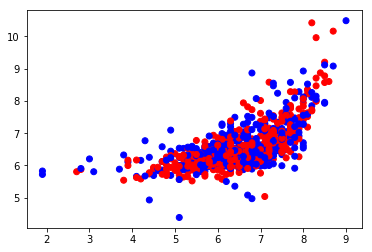

In [146]:
plt.scatter(Yte, y_pred, c=("red","blue"))   #scatter plot of actual vs predicted

## Singular Value Regression (SVR)

In [156]:
svr_rbf = SVR(kernel='rbf')
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

scores = cross_validate(svr_rbf, X_scaled, Y, cv=KFold(10, shuffle=True), scoring=scoring, return_train_score=False)

score = -1 * scores['test_neg_mean_absolute_error']
print("MAE: %.4f (%.4f)" % (score.mean(), score.std()))

score = -1 * scores['test_neg_mean_squared_error']
print("MSE: %.4f (%.4f)" % (score.mean(), score.std()))

score = scores['test_r2']
print("R^2: %.4f (%.4f)" % (score.mean(), score.std()))

MAE: 0.6689 (0.0365)
MSE: 0.7918 (0.0988)
R^2: 0.2908 (0.0337)


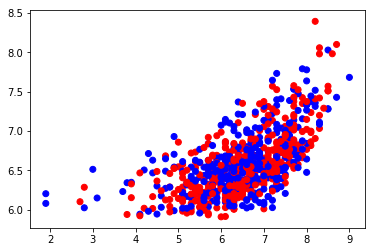

In [155]:
svr_rbf.fit(Xtr, Ytr)
svr_pred = svr_rbf.predict(Xte)
plt.scatter(Yte, svr_pred, c=("red","blue"))  #scatter plot of actual vs predicted